In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

读取数据

In [ ]:
data = pd.read_csv("train.csv")
data.head(), data.shape, data.describe()

数据探索

In [ ]:
#图形可视化，查看数据是否平衡
import seaborn as sns
sns.countplot(data.target)
plt.show()
#数据样本不均衡 需要继续后期处理

In [ ]:
#针对数据不平衡问题 我们进行随机欠采样来获取平衡的数据
y = data['target']
x = data.drop(['id', 'target'], axis=1)

rus = RandomUnderSampler(random_state=0)
x_resampled , y_resampled = rus.fit_resample(x, y)

#画图来验证一下效果
sns.countplot(y_resampled)
plt.show()

In [ ]:
# 把数据里的字符串数值化
le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)

分割数据

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2)

In [ ]:
#可视化
import seaborn as sns
sns.countplot(y_test)
plt.show()

In [ ]:
#通过StratifiedShuffleSplit实现数据分割
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, text_index in sss.split(x_resampled.values, y_resampled):
    print(len(train_index))
    print(len(text_index))

    x_train = x_resampled.values[train_index]
    x_val = x_resampled.values[text_index]

    y_train = y_resampled[train_index]
    y_val = y_resampled[text_index]

In [ ]:
x_train.shape, x_val.shape

In [ ]:
#可视化
import seaborn as sns
sns.countplot(y_val)
plt.show()

数据预处理

In [ ]:
#数据标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)

x_trian_scaled = scaler.transform(x_train)
x_val_scaled  = scaler.transform(x_val)
x_trian_scaled.shape

In [ ]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
x_train_pca = pca.fit_transform(x_trian_scaled)
x_val_pca = pca.transform(x_val_scaled)

x_train_pca.shape

In [ ]:
#可视化数据降维
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('元素数量')
plt.ylabel('表达信息占比')

plt.show()


模型训练

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train_pca, y_train)
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)>

In [ ]:
#输出预测值
y_pre_proba = xgb.predict_proba(x_val_pca)
y_pre_proba

In [ ]:
#logloss评估
from sklearn.metrics import log_loss
log_loss(y_val, y_pre_proba, eps=1e-15, normalize=True)

模型调优

In [ ]:
#n_estimators
scores_ne = []
n_estimators = [100, 200, 300, 400, 500, 525, 550, 575, 600, 700]

for nes in n_estimators:
    print('n_estimators', nes)
    xgb = XGBClassifier(max_depth = 3, 
                        learning_rate = 0.1, 
                        n_estimators = nes, 
                        objective='multi:softprob',
                        n_jobs = -1, 
                        nthread=4, 
                        min_child_weight = 1, 
                        subsample = 1, 
                        colsample_bytree=1, 
                        seed=42)
    xgb.fit(x_train_pca, y_train)
    y_pre = xgb.predict_proba(x_val_pca)
    score = log_loss(y_val, y_pre)
    scores_ne.append(score)

    print('每次运行的logloss值是：{}'.format(score))

#图形化展示
plt.plot(n_estimators, scores_ne, 'o-')
plt.xlabel('n_estimators')
plt.ylabel('log_loss')
plt.show()

print("最优的n_estimators是{}".format(n_estimators[np.argmin(scores_ne)]))


In [ ]:
#max_depth
scores_md = []
max_depth = [1,3,4,5,6,7]

for md in max_depth:
    print('max_depth', md)
    xgb = XGBClassifier(max_depth = md, 
                        learning_rate = 0.1, 
                        n_estimators =n_estimators[np.argmin(scores_ne)], 
                        objective='multi:softprob',
                        n_jobs = -1, 
                        nthread=4, 
                        min_child_weight = 1, 
                        subsample = 1, 
                        colsample_bytree=1, 
                        seed=42)
    xgb.fit(x_train_pca, y_train)
    y_pre = xgb.predict_proba(x_val_pca)
    score = log_loss(y_val, y_pre)
    scores_md.append(score)

    print('每次运行的logloss值是：{}'.format(score))

#图形化展示
plt.plot(max_depth, scores_md, 'o-')
plt.xlabel('max_depth')
plt.ylabel('log_loss')
plt.show()

print("最优的max_depth是{}".format(max_depth[np.argmin(scores_md)]))

min_child_weight 1
每次运行的logloss值是：0.6694499966782359
min_child_weight 3
每次运行的logloss值是：0.6693567873826096
min_child_weight 4
每次运行的logloss值是：0.6722866106012796
min_child_weight 5
每次运行的logloss值是：0.672005727165203
min_child_weight 6
每次运行的logloss值是：0.6722385162408542
min_child_weight 7
每次运行的logloss值是：0.6729959537525597


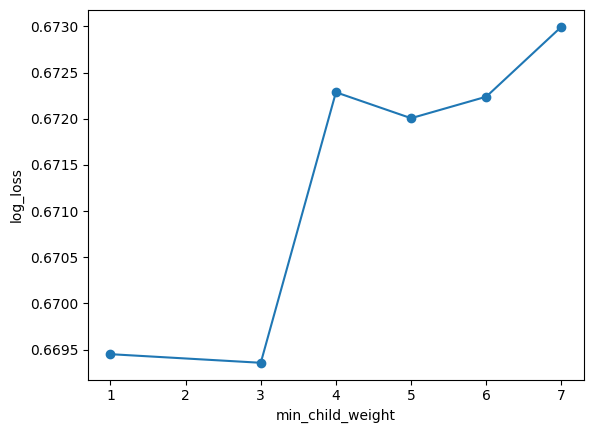

最优的min_child_weight是3


In [44]:
#min_child_weight
scores_mi = []
min_child_weight = [1,3,4,5,6,7]

for mi in min_child_weight:
    print('min_child_weight', mi)
    xgb = XGBClassifier(max_depth = max_depth[np.argmin(scores_md)], 
                        learning_rate = 0.1, 
                        n_estimators =n_estimators[np.argmin(scores_ne)], 
                        objective='multi:softprob',
                        n_jobs = -1, 
                        nthread=4, 
                        min_child_weight = mi, 
                        subsample = 1, 
                        colsample_bytree=1, 
                        seed=42)
    xgb.fit(x_train_pca, y_train)
    y_pre = xgb.predict_proba(x_val_pca)
    score = log_loss(y_val, y_pre)
    scores_mi.append(score)

    print('每次运行的logloss值是：{}'.format(score))

#图形化展示
plt.plot(min_child_weight, scores_mi, 'o-')
plt.xlabel('min_child_weight')
plt.ylabel('log_loss')
plt.show()

print("最优的min_child_weight是{}".format(min_child_weight[np.argmin(scores_mi)]))

subsample: 0.4
每次运行的logloss值是：0.67786844672591
subsample: 0.5
每次运行的logloss值是：0.6669866670618468
subsample: 0.6
每次运行的logloss值是：0.664449375280339
subsample: 0.7
每次运行的logloss值是：0.6673887397924161
subsample: 0.8
每次运行的logloss值是：0.6657148975657666
subsample: 0.9
每次运行的logloss值是：0.6649519373085704
subsample: 1.0
每次运行的logloss值是：0.6693567873826096


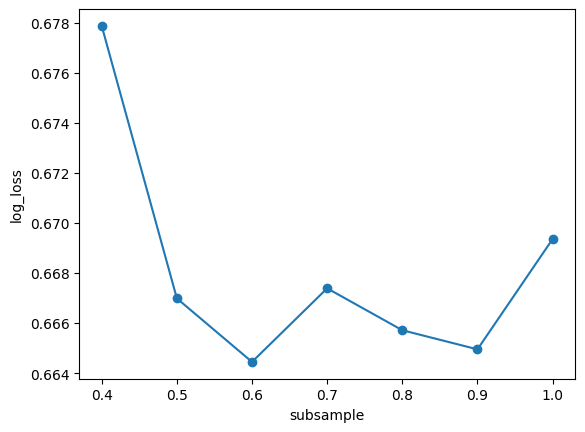

最优的subsample是0.6


In [46]:
scores_subsample = []
subsample_values = [0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.0]

for subsample in subsample_values:
    print('subsample:', subsample)
    xgb = XGBClassifier(max_depth=max_depth[np.argmin(scores_md)], 
                        learning_rate=0.1, 
                        n_estimators=n_estimators[np.argmin(scores_ne)], 
                        objective='multi:softprob',
                        n_jobs=-1, 
                        nthread=4, 
                        min_child_weight=min_child_weight[np.argmin(scores_mi)], 
                        subsample=subsample, 
                        colsample_bytree=1, 
                        seed=42)
    xgb.fit(x_train_pca, y_train)
    y_pred = xgb.predict_proba(x_val_pca)
    score = log_loss(y_val, y_pred)
    scores_subsample.append(score)

    print('每次运行的logloss值是：{}'.format(score))

# 图形化展示
plt.plot(subsample_values, scores_subsample, 'o-')
plt.xlabel('subsample')
plt.ylabel('log_loss')
plt.show()

print("最优的subsample是{}".format(subsample_values[np.argmin(scores_subsample)]))


colsample_bytree: 0.4
每次运行的logloss值是：0.6666297482146142
colsample_bytree: 0.5
每次运行的logloss值是：0.6634601621679481
colsample_bytree: 0.6
每次运行的logloss值是：0.6634487480583012
colsample_bytree: 0.7
每次运行的logloss值是：0.6682125962994395
colsample_bytree: 0.8
每次运行的logloss值是：0.6642505223561381
colsample_bytree: 0.9
每次运行的logloss值是：0.6710630499236245
colsample_bytree: 1.0
每次运行的logloss值是：0.664449375280339


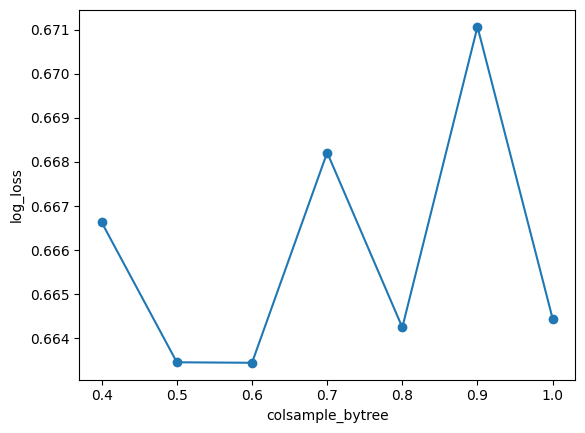

最优的colsample_bytree是0.6


In [47]:
scores_colsample_bytree = []
colsample_bytree_values = [0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.0]

for colsample_bytree in colsample_bytree_values:
    print('colsample_bytree:', colsample_bytree)
    xgb = XGBClassifier(max_depth=max_depth[np.argmin(scores_md)], 
                        learning_rate=0.1, 
                        n_estimators=n_estimators[np.argmin(scores_ne)], 
                        objective='multi:softprob',
                        n_jobs=-1, 
                        nthread=4, 
                        min_child_weight=min_child_weight[np.argmin(scores_mi)], 
                        subsample=subsample_values[np.argmin(scores_subsample)], 
                        colsample_bytree=colsample_bytree, 
                        seed=42)
    xgb.fit(x_train_pca, y_train)
    y_pred = xgb.predict_proba(x_val_pca)
    score = log_loss(y_val, y_pred)
    scores_colsample_bytree.append(score)

    print('每次运行的logloss值是：{}'.format(score))

# 图形化展示
plt.plot(colsample_bytree_values, scores_colsample_bytree, 'o-')
plt.xlabel('colsample_bytree')
plt.ylabel('log_loss')
plt.show()

print("最优的colsample_bytree是{}".format(colsample_bytree_values[np.argmin(scores_colsample_bytree)]))


learning_rate: 0.01
每次运行的logloss值是：0.8642357186368139
learning_rate: 0.05
每次运行的logloss值是：0.6776193743996889
learning_rate: 0.1
每次运行的logloss值是：0.6634487480583012
learning_rate: 0.2


c:\Users\18873\.conda\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


每次运行的logloss值是：0.7184064021631255
learning_rate: 0.3
每次运行的logloss值是：0.7860767653170827


c:\Users\18873\.conda\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


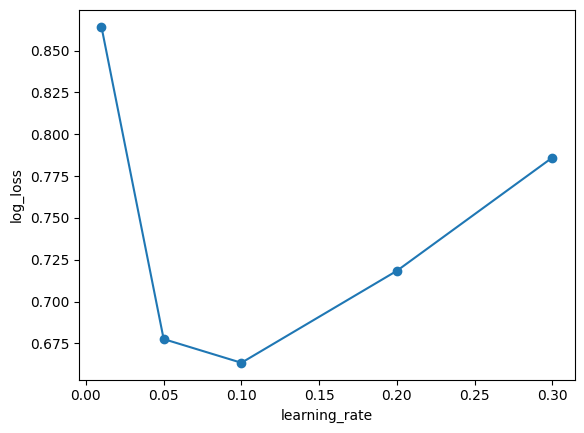

最优的learning_rate是0.1


In [48]:
scores_learning_rate = []
learning_rate_values = [0.01, 0.05, 0.1, 0.2, 0.3]

for lr in learning_rate_values:
    print('learning_rate:', lr)
    xgb = XGBClassifier(max_depth=max_depth[np.argmin(scores_md)], 
                        learning_rate=lr, 
                        n_estimators=n_estimators[np.argmin(scores_ne)], 
                        objective='multi:softprob',
                        n_jobs=-1, 
                        nthread=4, 
                        min_child_weight=min_child_weight[np.argmin(scores_mi)], 
                        subsample=subsample_values[np.argmin(scores_subsample)], 
                        colsample_bytree=colsample_bytree_values[np.argmin(scores_colsample_bytree)], 
                        seed=42)
    xgb.fit(x_train_pca, y_train)
    y_pred = xgb.predict_proba(x_val_pca)
    score = log_loss(y_val, y_pred)
    scores_learning_rate.append(score)

    print('每次运行的logloss值是：{}'.format(score))

# 图形化展示
plt.plot(learning_rate_values, scores_learning_rate, 'o-')
plt.xlabel('learning_rate')
plt.ylabel('log_loss')
plt.show()

print("最优的learning_rate是{}".format(learning_rate_values[np.argmin(scores_learning_rate)]))


确定最优参数模型


In [49]:
xgb = XGBClassifier(max_depth=max_depth[np.argmin(scores_md)], 
                            learning_rate=learning_rate_values[np.argmin(scores_learning_rate)], 
                            n_estimators=n_estimators[np.argmin(scores_ne)], 
                            objective='multi:softprob',
                            n_jobs=-1, 
                            nthread=4, 
                            min_child_weight=min_child_weight[np.argmin(scores_mi)], 
                            subsample=subsample_values[np.argmin(scores_subsample)], 
                            colsample_bytree=colsample_bytree_values[np.argmin(scores_colsample_bytree)], 
                            seed=42)

xgb.fit(x_train_pca, y_train)
y_pre = xgb.predict_proba(x_val_pca)
print('logloss{}'.format(log_loss(y_val, y_pre, eps=1e-15, normalize=True)))

logloss0.6634487437758325


c:\Users\18873\.conda\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:2851: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
c:\Users\18873\.conda\envs\d2l\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
